In [1]:
# Imports
import random
import optuna
import torch
import shutil
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from plotly import io as pio
from matplotlib import pyplot as plt
from optuna import visualization as opt_vis
from holidays import Germany
from multiprocessing import cpu_count
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, GroupNormalizer
from pytorch_forecasting.metrics.quantile import QuantileLoss
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

c:\Users\a829688\AppData\Local\anaconda3\envs\TFT\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
model_name = 'opt_tft'
seed_everything(69, workers=True)

Global seed set to 69


69

In [3]:
# Loading train data
train = pd.read_csv('../../Data/Raw/train/raw.csv')
train['Date'] = pd.to_datetime(train['Date'], dayfirst=True)
train = train[(train['Date'].dt.year >= 2018) & (train['Date'].dt.year <= 2022)]

train.tail()

,Date,Time,Datetime,50Hertz,Amprion,TenneT,TransnetBW,Total,Delta
280507,2022-12-31,22:45,2022-12-31 22:45:00,2361.75,3678.25,3187.25,1230.50,10457.75,0.00
280508,2022-12-31,23:00,2022-12-31 23:00:00,2292.50,3589.00,3194.75,1255.00,10331.25,0.00
280509,2022-12-31,23:15,2022-12-31 23:15:00,2280.75,3655.25,3156.50,1247.25,10339.50,0.25
280510,2022-12-31,23:30,2022-12-31 23:30:00,2274.75,3592.75,3140.00,1213.50,10220.75,0.25
280511,2022-12-31,23:45,2022-12-31 23:45:00,2237.50,3595.50,3085.25,1186.00,10104.25,0.00


In [4]:
# Loading test data
test = pd.read_csv('../../Data/Raw/test/raw.csv')

test.head()

,Date,Time,Datetime,50Hertz,Amprion,TenneT,TransnetBW,Total,Delta
0,01.01.2023,00:00,2023-01-01 00:00:00,2198.75,3349.50,3002.50,1170.00,9720.75,0.00
1,01.01.2023,00:15,2023-01-01 00:15:00,2186.00,3321.75,2978.75,1154.75,9641.25,0.00
2,01.01.2023,00:30,2023-01-01 00:30:00,2203.75,3300.00,2948.75,1157.25,9609.50,0.25
3,01.01.2023,00:45,2023-01-01 00:45:00,2225.75,3278.25,2907.25,1153.75,9565.00,0.00
4,01.01.2023,01:00,2023-01-01 01:00:00,2187.75,3231.75,2882.25,1171.75,9473.50,0.00


In [5]:
# Preparing data
def data_preparation(data, test=False, train_min_timestamp=0):
    # Melting variable columns
    data = pd.melt(data, id_vars=['Datetime', 'Date', 'Time'], value_vars=['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta'], var_name='control_area', value_name='power_consumption')

    # Convert 'Datetime' column to datetime objects
    data['Datetime'] = pd.to_datetime(data['Datetime'])

    # Numericals
    # Calculate Unix timestamp
    data['unix_timestamp'] = data['Datetime'].apply(lambda x: int(x.timestamp()))

    # Setting the start index
    if test==False:
        min_timestamp = data['unix_timestamp'].min()
    elif test==True:
        min_timestamp = train_min_timestamp

    # Calculate passed time intervals
    data['quarter_hours_from_start'] = (data['unix_timestamp'] - min_timestamp) // 900
    data['hours_from_start'] = (data['unix_timestamp'] - min_timestamp) // 3600
    data['days_from_start'] = (data['unix_timestamp'] - min_timestamp) // 86400
    data['weeks_from_start'] = (data['unix_timestamp'] - min_timestamp) // 604800
    data['months_from_start'] = (data['unix_timestamp'] - min_timestamp) // 2629743
    data['years_from_start'] = (data['unix_timestamp'] - min_timestamp) // 31556926

    # Extract date components
    data['hour_of_day'] = data['Datetime'].dt.hour
    data['minute_of_hour'] = data['Datetime'].dt.minute
    data['day_of_week'] = data['Datetime'].dt.dayofweek
    data['day_of_year'] = data['Datetime'].dt.dayofyear
    data['month_of_year'] = data['Datetime'].dt.month
    data['year'] = data['Datetime'].dt.year
    data['quarter'] = data['Datetime'].dt.quarter

    #Categricals
    # Check if it's a weekend or holiday
    holidays = Germany(years=range(2015, 2024), language='en_US')
    data['is_weekend'] = (data['Datetime'].dt.dayofweek >= 5).astype(str)
    data['is_holiday'] = data['Date'].apply(lambda x: str(x in holidays))

    # Add name of holiday if is_holiday is 1
    data['holiday_name'] = data.apply(lambda row: holidays.get(row['Date']) if row['is_holiday'] == 'True' else 'None', axis=1)

    # Add name of weekday
    data['weekday_name'] = data['Datetime'].dt.day_name()

    return data

In [6]:
# Transforming train data
train = data_preparation(train)
train.to_csv('../../Data/processed/train/tft_input.csv', index=False)

train.tail()

,Datetime,Date,Time,control_area,power_consumption,unix_timestamp,quarter_hours_from_start,hours_from_start,days_from_start,weeks_from_start,...,minute_of_hour,day_of_week,day_of_year,month_of_year,year,quarter,is_weekend,is_holiday,holiday_name,weekday_name
1051771,2022-12-31 22:45:00,2022-12-31,22:45,Delta,0.00,1672526700,175291,43822,1825,260,...,45,5,365,12,2022,4,True,False,None,Saturday
1051772,2022-12-31 23:00:00,2022-12-31,23:00,Delta,0.00,1672527600,175292,43823,1825,260,...,0,5,365,12,2022,4,True,False,None,Saturday
1051773,2022-12-31 23:15:00,2022-12-31,23:15,Delta,0.25,1672528500,175293,43823,1825,260,...,15,5,365,12,2022,4,True,False,None,Saturday
1051774,2022-12-31 23:30:00,2022-12-31,23:30,Delta,0.25,1672529400,175294,43823,1825,260,...,30,5,365,12,2022,4,True,False,None,Saturday
1051775,2022-12-31 23:45:00,2022-12-31,23:45,Delta,0.00,1672530300,175295,43823,1825,260,...,45,5,365,12,2022,4,True,False,None,Saturday


In [7]:
# Transforming test data
test = data_preparation(test, test=True, train_min_timestamp=1420070400)
test.to_csv('../../Data/processed/test/tft_input.csv', index=False)

test.head()

,Datetime,Date,Time,control_area,power_consumption,unix_timestamp,quarter_hours_from_start,hours_from_start,days_from_start,weeks_from_start,...,minute_of_hour,day_of_week,day_of_year,month_of_year,year,quarter,is_weekend,is_holiday,holiday_name,weekday_name
0,2023-01-01 00:00:00,01.01.2023,00:00,50Hertz,2198.75,1672531200,280512,70128,2922,417,...,0,6,1,1,2023,1,True,True,New Year's Day,Sunday
1,2023-01-01 00:15:00,01.01.2023,00:15,50Hertz,2186.00,1672532100,280513,70128,2922,417,...,15,6,1,1,2023,1,True,True,New Year's Day,Sunday
2,2023-01-01 00:30:00,01.01.2023,00:30,50Hertz,2203.75,1672533000,280514,70128,2922,417,...,30,6,1,1,2023,1,True,True,New Year's Day,Sunday
3,2023-01-01 00:45:00,01.01.2023,00:45,50Hertz,2225.75,1672533900,280515,70128,2922,417,...,45,6,1,1,2023,1,True,True,New Year's Day,Sunday
4,2023-01-01 01:00:00,01.01.2023,01:00,50Hertz,2187.75,1672534800,280516,70129,2922,417,...,0,6,1,1,2023,1,True,True,New Year's Day,Sunday


In [ ]:
# Dataset

# Preparing dataset
max_prediction_length = 4*24*7 # a week in quarterhours
max_encoder_length = 4*24*7
training_cutoff = train['quarter_hours_from_start'].max() - max_prediction_length

#TSDS pytorch forecasting with given arguments
training_set = TimeSeriesDataSet(
    data=train[lambda x: x.quarter_hours_from_start <= training_cutoff],
    time_idx='quarter_hours_from_start',
    target='power_consumption',
    group_ids=['control_area'],
    max_encoder_length=max_encoder_length,
    min_encoder_length=4*24,
    min_prediction_length=4*24,
    max_prediction_length=max_prediction_length,
    static_categoricals=['control_area'],
    time_varying_known_categoricals=['is_weekend', 'is_holiday', 'holiday_name', 'weekday_name'],
    time_varying_known_reals=['unix_timestamp', 'quarter_hours_from_start', 'hours_from_start', 
                            'days_from_start', 'weeks_from_start', 'months_from_start', 
                            'years_from_start', 'hour_of_day', 'minute_of_hour', 
                            'day_of_week', 'day_of_year', 'month_of_year', 
                            'year', 'quarter'],
    time_varying_unknown_reals=['power_consumption'],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    target_normalizer=GroupNormalizer(groups=['control_area'], transformation='softplus'))

#Split validation set
validation_set = TimeSeriesDataSet.from_dataset(training_set, train, predict=True, stop_randomization=True)

In [ ]:
it_count = 0
def objective(trial):
    global it_count

    batch_size = trial.suggest_int('batch_size', 4*24, 4*24*7, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    gradient_clipping_value = trial.suggest_float('gradient_clipping_value', 1e-2, 0.9, log=True)
    drop_out = trial.suggest_float('drop_out', 0.1, 0.9, log=True)

    #Build dataloader
    workers = cpu_count()
    train_dataloader = training_set.to_dataloader(train=True, batch_size=batch_size, num_workers=workers, persistent_workers=True)
    val_dataloader = validation_set.to_dataloader(train=False, batch_size=batch_size, num_workers=workers, persistent_workers=True)

    # Model definition  

    # Actual model
    tft = TemporalFusionTransformer.from_dataset(
        training_set,
        hidden_size=8,
        lstm_layers=2,
        dropout=drop_out, ## observed
        output_size=7,
        loss=QuantileLoss(),
        attention_head_size=4,
        learning_rate=learning_rate, ## observed
        log_interval=4*24,
        log_val_interval=4*24,
        log_gradient_flow=False,
        reduce_on_plateau_patience=1000,
        logging_metrics=None)

    # Outside features
    early_stop_callback = EarlyStopping(monitor='val_loss', 
                            min_delta=0.1,
                            patience=3,
                            verbose=True, 
                            mode='min')
    lr_logger = LearningRateMonitor()  
    logger = TensorBoardLogger(f'tensorboard/run_{it_count}')

    # Trainer instance
    trainer = Trainer(
        max_epochs=15,
        accelerator = 'gpu',
        devices = 1,
        enable_model_summary=True,
        gradient_clip_val=gradient_clipping_value, ## observed
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
        log_every_n_steps=15)
    
    # Model training
    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

    # Save optimization step
    trainer.save_checkpoint(f'optimized_model_{it_count}.ckpt')
    it_count += 1

    return trainer.callback_metrics["val_loss"].item()

In [ ]:
# Hyperparameter optimization
torch.set_float32_matmul_precision('high')
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

In [ ]:
# Saving best model
best_trial = study.best_trial.number

shutil.move(f'optimized_model_{best_trial}.ckpt', f'{model_name}.ckpt')

In [ ]:
# Plots of optimization

history_fig = opt_vis.plot_optimization_history(study)
pio.write_image(history_fig, 'optuna_history.png', format="png")

parallel_fig = opt_vis.plot_parallel_coordinate(study)
pio.write_image(parallel_fig, 'optuna_parallel.png', format="png")

In [8]:
# Importing best model
tft = TemporalFusionTransformer.load_from_checkpoint(f'{model_name}.ckpt')

c:\Users\a829688\AppData\Local\anaconda3\envs\TFT\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\a829688\AppData\Local\anaconda3\envs\TFT\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [9]:
def get_predictions_and_actuals(start_date, end_date):
    predicted_length = int((end_date - start_date).total_seconds() / (15 * 60))

    timestamp_end = start_date.timestamp()

    timestamp_start = timestamp_end - ((15 * 60) * (4*24*8))

    if predicted_length <= 4*24*7:
        test_range = test[(test['unix_timestamp'] >= timestamp_start) & (test['unix_timestamp'] <= timestamp_end)].reset_index(drop=True)

        prediction_array = tft.predict(test_range, return_index=True)

        control_areas = prediction_array[1]['control_area'].to_list()

        pred_df = pd.DataFrame()

        for i in range(len(control_areas)):
            pred_df[control_areas[i]] = prediction_array[0].numpy().tolist()[i][:predicted_length]
    else:
        pred_df = pd.DataFrame()
        remaining_steps = predicted_length
        while remaining_steps > 0:
            current_prediction_length = min(remaining_steps, 4*24*7)
            
            # Predict the next interval
            test_range = test[(test['unix_timestamp'] >= timestamp_start) & (test['unix_timestamp'] <= timestamp_end)].reset_index(drop=True)
            prediction_array = tft.predict(test_range, return_index=True)
            control_areas = prediction_array[1]['control_area'].to_list()

            # Accumulate predictions for the current interval
            temp_df = pd.DataFrame()
            for i in range(len(control_areas)):
                temp_df[control_areas[i]] = prediction_array[0].numpy().tolist()[i]
            
            pred_df = pd.concat([pred_df, temp_df], axis=0, ignore_index=True)

            # Update time range
            timestamp_end += current_prediction_length * (15*60)
            timestamp_start = timestamp_end - (900 * (4*24*8))

            # Update remaining steps
            remaining_steps -= current_prediction_length

    test_data_start = start_date.timestamp() - (15*60)
    test_data_end = test_data_start + (predicted_length * (15*60))

    test_data = test[(test['unix_timestamp'] > test_data_start) & (test['unix_timestamp'] <= test_data_end)]

    test_df = test_data.pivot(index=[x for x in list(test_data.columns) if x not in ['control_area', 'power_consumption']], 
            columns='control_area', 
            values='power_consumption').reset_index()
    
    pred_df = pred_df[['50Hertz', 'Amprion', 'TenneT', 'TransnetBW', 'Total', 'Delta']]

    if len(pred_df) != len(test_df):
        if len(pred_df) < len(test_df):
            test_df = test_df[:len(pred_df)]
        elif len(test_df) < len(pred_df):
            pred_df = pred_df[:len(test_df)]

    return pred_df, test_df

In [10]:
# Performance calculation
def performance_check(y, y_hat):
    raw_mape = mean_absolute_percentage_error(y, y_hat)
    raw_sdmae = mean_absolute_error(y, y_hat) / np.std(y)
    return raw_mape, raw_sdmae

# Perfromance evaluation
def performance_evaluation(n_iter, n_days):
    metrics = []
    start_date = datetime(2023, 1, 31)
    end_date = datetime(2023, 7, 31)
    date_range = (end_date - start_date).days - n_days
    
    for i in range(n_iter):
        random_days_offset = random.randint(0, date_range)
        random_start_date = start_date + timedelta(days=random_days_offset)
        random_end_date = random_start_date + timedelta(days=n_days)

        pred_df, test_df = get_predictions_and_actuals(random_start_date, random_end_date)

        for n in pred_df.columns:
            mape, sdmae = performance_check(test_df[n], pred_df[n])
            metrics.append((n, mape, sdmae))
    
    metrics_df = pd.DataFrame(metrics, columns=['control_area', 'mape', 'sdmae'])
    grouped_df = metrics_df.groupby('control_area').agg({'mape': 'mean', 'sdmae': 'mean'}).reset_index()
    output_df = grouped_df.rename(columns={'mape': 'avg_mape', 'sdmae': 'avg_sdmae'})
        
    return output_df

# Metric formatting for plotting
def metric_formatting(raw_mape, raw_sdmae):
    if raw_mape < 1:
        mape = f'{round(raw_mape*100, 2)}%'
    else:
        mape = 'too high'
    if raw_sdmae < 1:
        sdmae = round(raw_sdmae, 4)
    else:
        sdmae = 'too high'
    return mape, sdmae

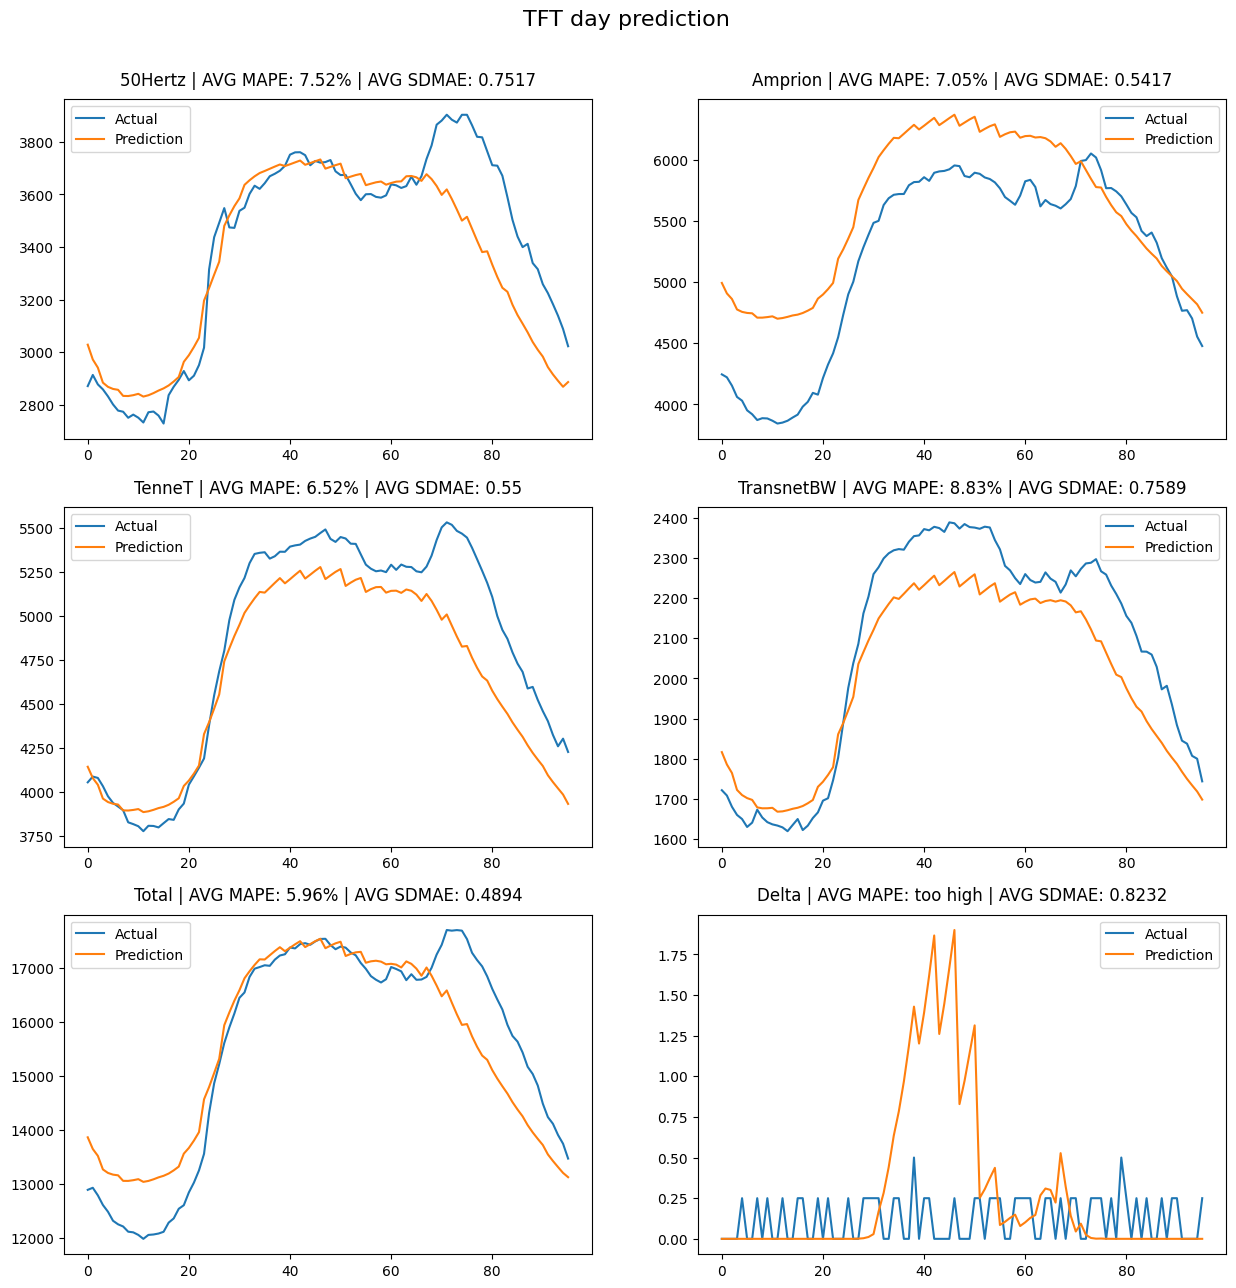

In [11]:
# Plotting predictions against test data
day_mape = []
day_sdmae = []
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('01.02.2023', dayfirst=True)
end_date = pd.to_datetime('02.02.2023', dayfirst=True)

# Get predictions and actuals
pred_df, test_df= get_predictions_and_actuals(start_date, end_date)

fig.suptitle('TFT day prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = list(pred_df.columns)[i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 1)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()
        day_mape.append(mape)
        day_sdmae.append(sdmae)

plt.savefig(f'{model_name}_day_prediction.svg', format='svg')

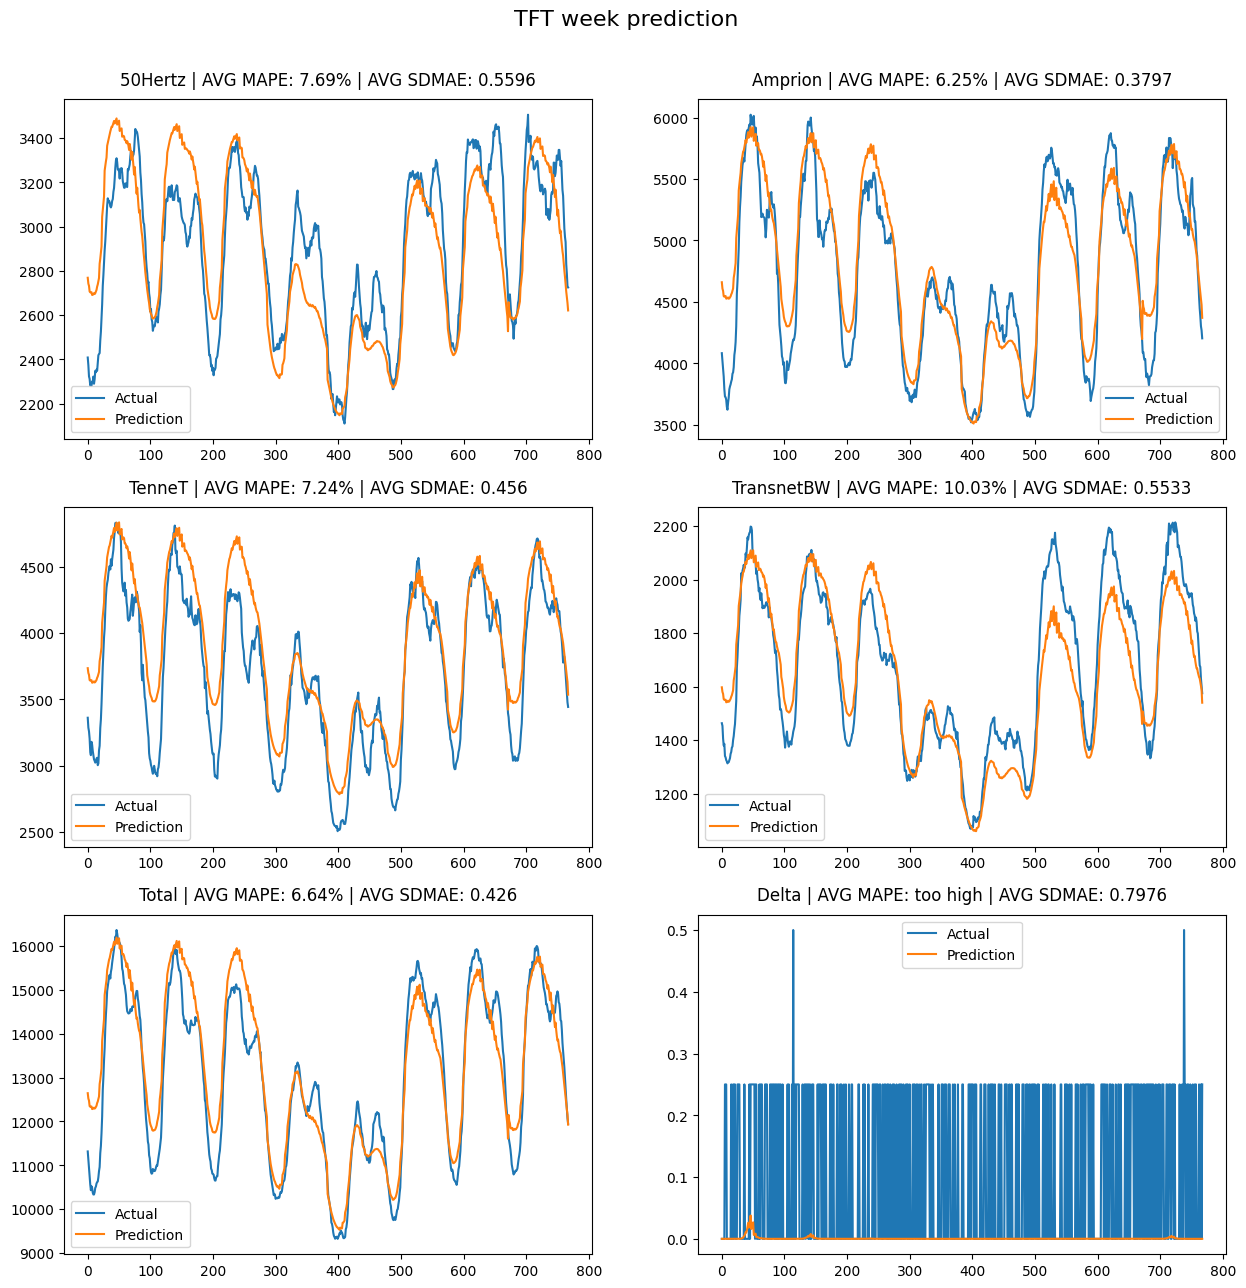

In [12]:
# Plotting predictions against test data
week_mape = []
week_sdmae = []
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('12.04.2023', dayfirst=True)
end_date = pd.to_datetime('20.04.2023', dayfirst=True)

# Get predictions and actuals
pred_df, test_df= get_predictions_and_actuals(start_date, end_date)

fig.suptitle('TFT week prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = list(pred_df.columns)[i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 7)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()
        week_mape.append(mape)
        week_sdmae.append(sdmae)

plt.savefig(f'{model_name}_week_prediction.svg', format='svg')

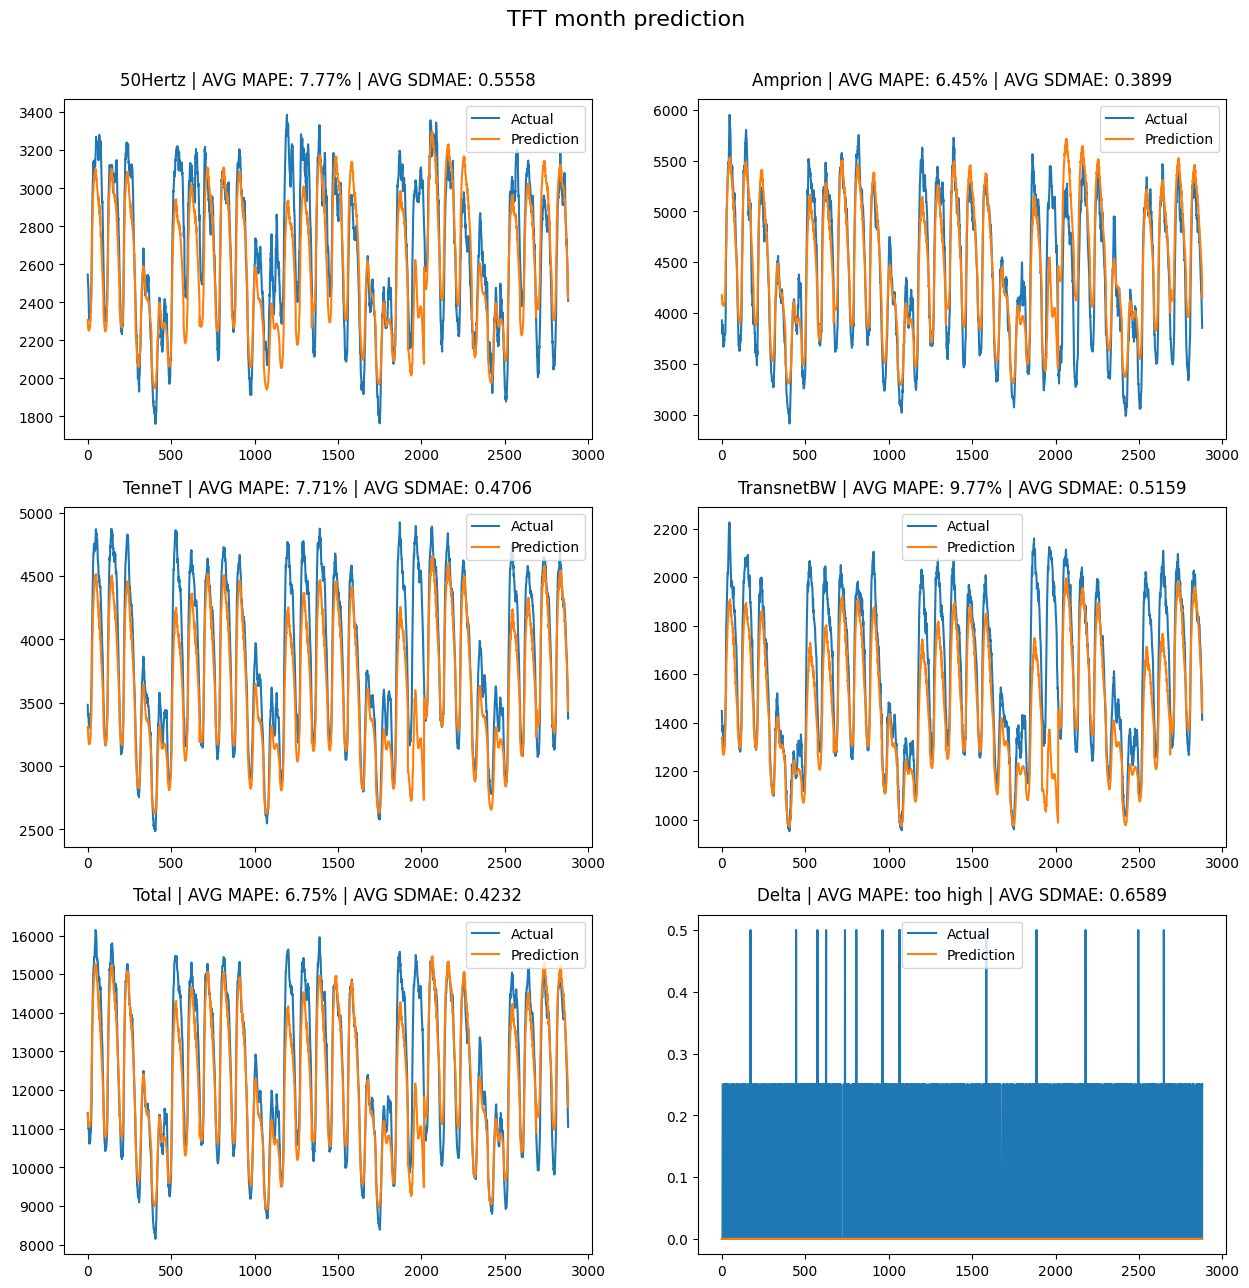

In [13]:
# Plotting predictions against test data
month_mape = []
month_sdmae = []
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('21.06.2023', dayfirst=True)
end_date = pd.to_datetime('21.07.2023', dayfirst=True)

# Get predictions and actuals
pred_df, test_df= get_predictions_and_actuals(start_date, end_date)

fig.suptitle('TFT month prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = list(pred_df.columns)[i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        metric_df = performance_evaluation(100, 30)
        mape, sdmae = metric_formatting(metric_df.loc[metric_df['control_area'] == control_area, 'avg_mape'].values[0],
                                        metric_df.loc[metric_df['control_area'] == control_area, 'avg_sdmae'].values[0])

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()
        month_mape.append(mape)
        month_sdmae.append(sdmae)

plt.savefig(f'{model_name}_month_prediction.svg', format='svg')

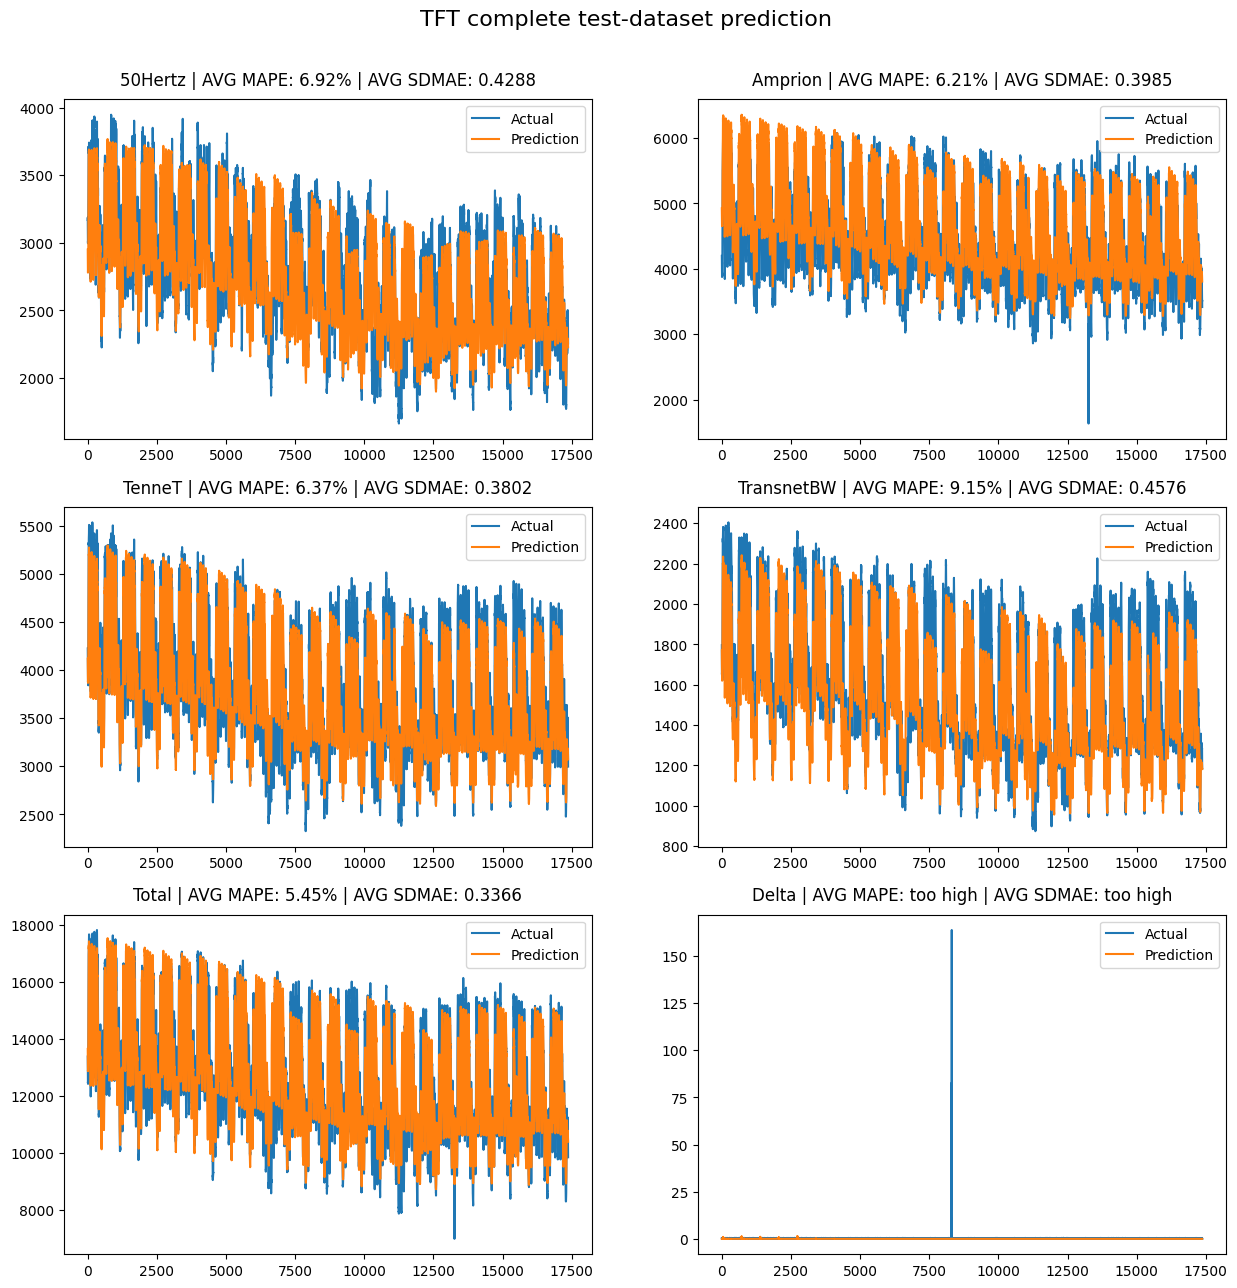

In [14]:
# Plotting predictions against test data
complete_mape = []
complete_sdmae = []
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# Set test interval
start_date = pd.to_datetime('31.01.2023', dayfirst=True)
end_date = pd.to_datetime('31.07.2023', dayfirst=True)

# Get predictions and actuals
pred_df, test_df= get_predictions_and_actuals(start_date, end_date)

fig.suptitle('TFT complete test-dataset prediction', fontsize=16, y=0.94)

for i in range(3):
    for j in range(2):
        control_area = list(pred_df.columns)[i * 2 + j]

        pred_data = pred_df[control_area]
        actual_data = test_df[control_area]

        mape, sdmae = metric_formatting(*performance_check(pred_data, actual_data))

        ax[i][j].plot(actual_data.reset_index(drop=True), label='Actual')
        ax[i][j].plot(pred_data.reset_index(drop=True), label='Prediction')
        ax[i][j].set_title(control_area)
        ax[i][j].set_title(f'{control_area} | AVG MAPE: {mape} | AVG SDMAE: {sdmae}', loc="center", pad=10)
        ax[i][j].legend()
        complete_mape.append(mape)
        complete_sdmae.append(sdmae)

plt.savefig(f'{model_name}_complete_prediction.svg', format='svg')

In [15]:
df_mape = pd.DataFrame()
df_mape['day'] = day_mape
df_mape['week'] = week_mape
df_mape['month'] = month_mape
df_mape['complete'] = complete_mape
df_mape.to_csv(f'{model_name}_mape.csv', index=False)

df_sdmae = pd.DataFrame()
df_sdmae['day'] = day_sdmae
df_sdmae['week'] = week_sdmae
df_sdmae['month'] = month_sdmae
df_sdmae['complete'] = complete_sdmae
df_sdmae.to_csv(f'{model_name}_sdmae.csv', index=False)